<table class="table table-bordered">
    <tr>
        <th style="text-align:center;"><h1>Supervised Machine Learning</h1><h2>Lab 3 - Decision Tree </h2></th>
    </tr>
</table>

In [2]:
# Import the requried packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model, neighbors, tree, svm, ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate

### 1.Classification

We will be using the bank marketing campaign data for classification task. We commented out the data scaling part of codes, as Decision Tree is known to perform well even without data scalling, but of course it will perform equally well with data scaling.  

In [3]:
# Loading the data
bank = pd.read_csv('bank.csv')
print(bank.head())
# Encode the categorical data into numbers
bank_cat = bank.select_dtypes(['object']).copy()
for col in bank_cat:
    print(col, ':')
    codes, uniques = pd.factorize(bank_cat[col], sort=True)
    bank[col]=codes
    print(uniques)
print(bank.head())
    
# Set the "deposit" as target/model output and the rest features as model inputs
y = bank['deposit']
X = bank.drop(['deposit'], axis=1)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#Sacaling the data into a smaller range (-3 to +3)
#mean = X_train.mean()
#std = X_train.std()

#X_train = (X_train - mean) / std
#X_test = (X_test - mean) / std


   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  
job :
Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 

#### 1.1 Baseline Model

In [4]:
#Decision Tree Model
dt_clf = tree.DecisionTreeClassifier(max_depth=4) # set the depth of tree as 3
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [5]:
print('train_acc:', dt_clf.score(X_train, y_train), 
      '\n test_acc:', dt_clf.score(X_test, y_test))

train_acc: 0.7944898644865046 
 test_acc: 0.7881773399014779


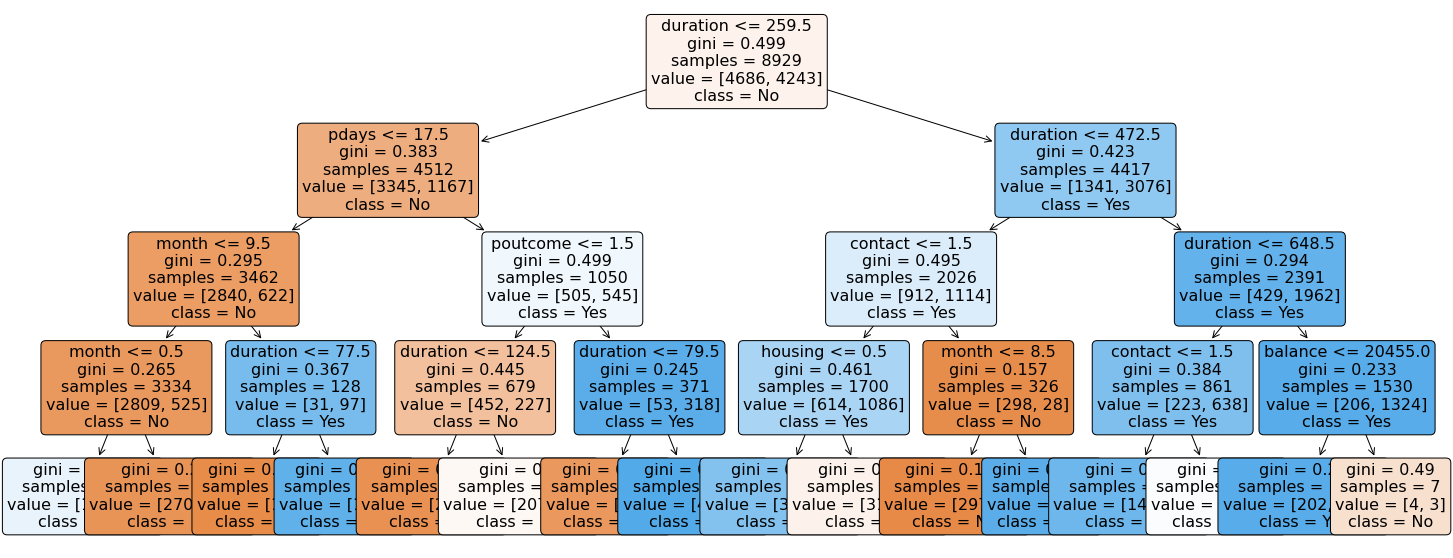

In [6]:
plt.figure(figsize=(25,10))
tree.plot_tree(dt_clf,
               feature_names = X_train.columns,
               class_names = ['No', 'Yes'],
               rounded = True,
               filled= True,
               fontsize =16)
plt.show()   

#### 1.2 Tuning Model Hyperparameter: max_depth

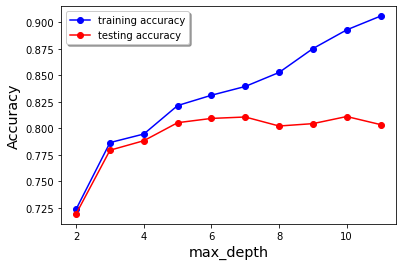

In [7]:
# Find the best max_depth
depth_range = range(2,12) # ranges from 2 to 12
train_accuracy = []
test_accuracy = []

for d in depth_range:
    dt_clf = tree.DecisionTreeClassifier(max_depth=d)
    dt_clf.fit(X_train, y_train) 
    train_accuracy.append(dt_clf.score(X_train, y_train))
    test_accuracy.append(dt_clf.score(X_test, y_test))
    
#Plot the train & test accuracy
plt.plot(depth_range, train_accuracy, 'bo-', label ='training accuracy')
plt.plot(depth_range, test_accuracy, 'ro-', label = 'testing accuracy')

plt.xlabel('max_depth', fontsize='x-large')
plt.ylabel('Accuracy', fontsize='x-large')

plt.legend(loc='best', shadow=True)
plt.show()

In [26]:
2+np.argmax(test_accuracy)

10

In [27]:
#Decision Tree Model
dt_clf = tree.DecisionTreeClassifier(max_depth=10) # set the best max_depth
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [28]:
print('train_acc:', dt_clf.score(X_train, y_train), 
      '\n test_acc:', dt_clf.score(X_test, y_test))

train_acc: 0.8927091499608019 
 test_acc: 0.8092252575011196


#### 1.3 Tuning Multiple Model Hyperparameters using GridSearchCV

The `DecisionTreeClassifier` has a few model hyperparameters which restrict the shape of Decision Tree, e.g:
* `criterion`: the metrics used to measure the impurity of each node (e.g. gini, entropy and etc.);
* `min_samples_leaf`: the minimum number of samples a leaf node must have;
* `min_samples_split`: the minimum number of samples a node must have before it can be split;
* `max_depth`: the maximum depth of the tree.

Earlier we only adjusted `max_depth` but what if we want to adjust all the above mentioned hyperparameters? It would be a very tedious work to do this manually, i.e. try and explore all the possible combinations and find the best set of values. 

Instead you should get Scikit-Learn's `GridSearchCV` to search for you. All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation.

K-folds Cross Validation is useful to get the best model hyperparameters. We randomly split the train data into 5 folds (K=5) and then train & validate the Decision Tree model 5 times, picking a different fold for validation every time and training on the other 4 folds. The result is an array containing the 5 accuracy scores for both training and validation scores: 

In [10]:
X_train.shape

(8929, 16)

In [11]:
8929/5

1785.8

In [12]:
from sklearn.model_selection import cross_val_score, cross_validate

# Evaluate the Model using K-folds Cross validation
results  = cross_validate(dt_clf, X_train, y_train, scoring='accuracy', cv=5, return_train_score=True)
print('train_score: ', results['train_score'])
print('val_score: ', results['test_score'])

train_score:  [0.91180176 0.90970181 0.90354193 0.90844183 0.91363382]
val_score:  [0.80291153 0.82362822 0.80347144 0.79955207 0.79943978]


In [13]:
# Use GridSearch to find the best combination of model hyperparameters
from sklearn.model_selection import GridSearchCV

dt_clf = tree.DecisionTreeClassifier()

param_grid = { "criterion" : ['gini','entropy'],              
              "min_samples_leaf" : [1,5,10], 
              "min_samples_split" : [10,12,16,20,24], 
              'max_depth' : range(5,11)
             }

gs_clf = GridSearchCV(dt_clf, param_grid=param_grid, scoring='accuracy', cv= 5, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 11),
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [10, 12, 16, 20, 24]},
             scoring='accuracy')

In [14]:
print(gs_clf.best_score_)
print(gs_clf.best_params_)
print(gs_clf.best_estimator_)

0.8227114720468254
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=20)


In [15]:
cvres = gs_clf.cv_results_
for acc, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(acc, params)

0.8012099083754443 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.8013218904583109 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 12}
0.8013218904583109 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 16}
0.8012099083754443 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 20}
0.8010979262925775 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 24}
0.8013217649881901 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.8013217649881901 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 12}
0.8013217649881901 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 16}
0.8014337470710569 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20}
0.8012097829053234 {'criterion': 'gini', 'max_depth': 5

In [16]:
#Decision Tree Final Model (Option 1)
dt_clf = tree.DecisionTreeClassifier(criterion ='entropy', 
                                     max_depth = 10, 
                                     min_samples_leaf = 5, 
                                     min_samples_split = 20
                                    )
#another approach - assign directly 
dt_clf = tree.DecisionTreeClassifier(criterion ='entropy', 
                                     max_depth = 10, 
                                     min_samples_leaf = 5, 
                                     min_samples_split = 20
                                    )
dt_clf.fit(X_train, y_train)

print('train_acc:', dt_clf.score(X_train, y_train), 
      '\n test_acc:', dt_clf.score(X_test, y_test))

train_acc: 0.86146264979281 
 test_acc: 0.8235557545902373


In [17]:
#Decision Tree Final Model (Option 2)
dt_clf = tree.DecisionTreeClassifier(criterion ='entropy', 
                                     max_depth = 10, 
                                     min_samples_leaf = 5, 
                                     min_samples_split = 20
                                    )
dt_clf.fit(X_train, y_train)

print('train_acc:', dt_clf.score(X_train, y_train), 
      '\n test_acc:', dt_clf.score(X_test, y_test))

train_acc: 0.86146264979281 
 test_acc: 0.8235557545902373


### 3. Regression
We will be using the supermarket data for regression task. 

In [15]:
# Loading the data
supermarket = pd.read_csv('supermarket.csv')
print(supermarket.head())

# Encode the categorical data into numbers
supermarket_cat = supermarket.select_dtypes(['object']).copy()
for col in supermarket_cat:
    print(col, ':')
    codes, uniques = pd.factorize(supermarket_cat[col], sort=True)
    supermarket[col]=codes
    print(uniques)
print(supermarket.head())

# Set the "Sales" as target/model output and the rest features as model inputs
y = supermarket['Item_Outlet_Sales']
X = supermarket.drop(['Item_Outlet_Sales'], axis=1)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#Sacaling the data into a smaller range (-3 to +3)
#mean = X_train.mean()
#std = X_train.std()

#X_train = (X_train - mean) / std
#X_test = (X_test - mean) / std

   Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
0         9.30          Low Fat         0.016047                  Dairy   
1         5.92          Regular         0.019278            Soft Drinks   
2        17.50          Low Fat         0.016760                   Meat   
3        19.20          Regular         0.000000  Fruits and Vegetables   
4         8.93          Low Fat         0.000000              Household   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  249.8092            OUT049                       1999      Medium   
1   48.2692            OUT018                       2009      Medium   
2  141.6180            OUT049                       1999      Medium   
3  182.0950            OUT010                       1998         NaN   
4   53.8614            OUT013                       1987        High   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
0               Tier 1  Supermarket Type1          37

In [44]:
#Decision Tree Model
dt_reg = tree.DecisionTreeRegressor(criterion = 'mse', max_depth=3)
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [45]:
print('train_mae:', mean_absolute_error(dt_reg.predict(X_train), y_train), 
      '\n test_mae:', mean_absolute_error(dt_reg.predict(X_test), y_test))

train_mae: 0.3188934442928149 
 test_mae: 0.32383302401201697


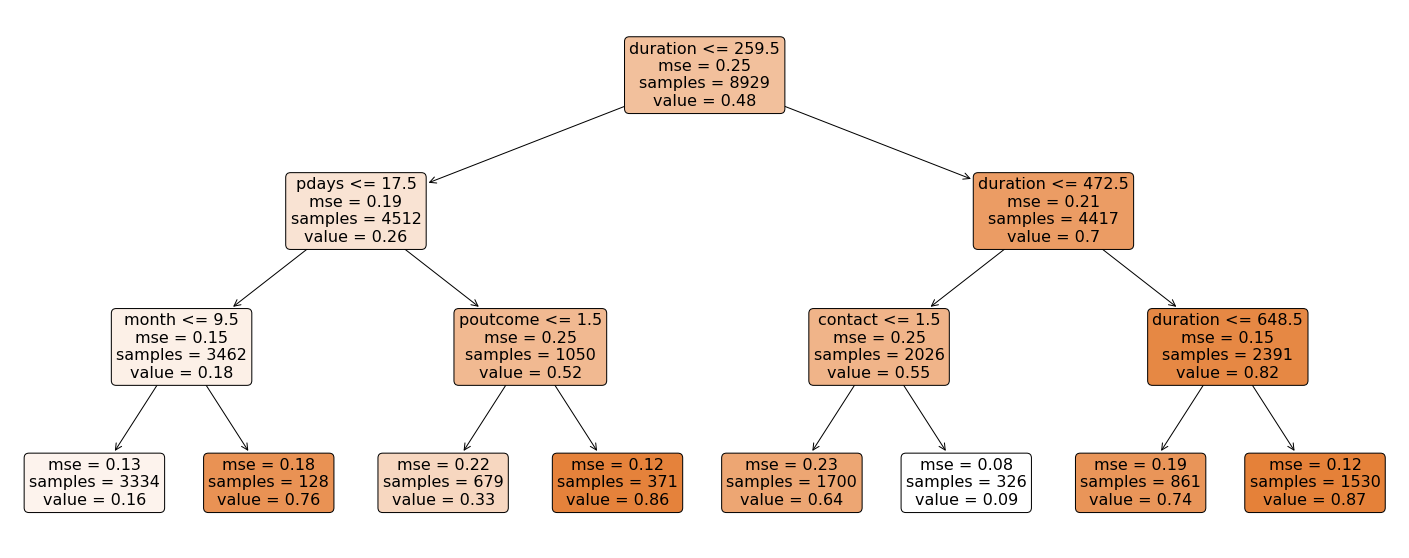

In [46]:
plt.figure(figsize=(25,10))
tree.plot_tree(dt_reg,
               feature_names = X_train.columns,
               rounded = True,
               filled= True,
               precision =2, 
               fontsize =16)
plt.show() 

In [47]:
# Use GridSearch to find the best combination of model hyperparameters

param_grid = {"criterion" : ['mse','friedman_mse'], 
              'max_depth' : range(2,7)}

gs_reg = GridSearchCV(dt_reg, param_grid=param_grid, scoring ='neg_mean_squared_error', cv=5, n_jobs=-1)

gs_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse'],
                         'max_depth': range(2, 7)},
             scoring='neg_mean_squared_error')

In [48]:
print(gs_reg.best_score_)
print(gs_reg.best_params_)
print(gs_reg.best_estimator_)

-0.14007142733277989
{'criterion': 'mse', 'max_depth': 6}
DecisionTreeRegressor(max_depth=6)


In [49]:
#Decision Tree Final Model
dt_reg = gs_reg.best_estimator_
dt_reg.fit(X_train, y_train)

print('train_mae:', mean_absolute_error(dt_reg.predict(X_train), y_train), 
      '\n test_mae:', mean_absolute_error(dt_reg.predict(X_test), y_test))

train_mae: 0.25332925054186084 
 test_mae: 0.2668791077963192


In [50]:
dt_reg.score(X_test, y_test)

0.43340689491631723